# Time Series Anomaly Detection by Image Classification

## Preface

One of my day jobs working in a IC design house is to help our sensor be well manufactured through the process. Root-causing every manufacture failure from the factory is one the important thing in the process. I found a dataset of time series that someone worked with experts to label with time periods that they want to target.

(unfinished...)

## Imports

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [ ]:
plt.style.use(['dark_background'])

## Paths

In [ ]:
DATA_PATH = Config.data_path()
PATH = DATA_PATH/'anomaly'
PATH.ls()

[PosixPath('/home/achen/.fastai/data/anomaly/anomaly'),
 PosixPath('/home/achen/.fastai/data/anomaly/models'),
 PosixPath('/home/achen/.fastai/data/anomaly/normal')]

## Data Preparation

The time series dataset is a Microsoft dataset that includes a variety of distinct problem domains such as cloud service request rates, product purchase counts, application crash rates, and API latencies. The dataset is annotated with anomalies - that is, time slices where experts have indicated that they want to be notified to investigate for possible issues.  

The dataset contains over 100 distinct anomalies. I generated bitmaps of the time series charts with the anomaly time slices at the right edge of the chart. Then I took a random sample of around 400 time windows of non-anomalous time series and generated bitmaps of those as well.

I initially had issues reading in these images in the way I want with the `fast.ai` library. The default behavior of `fast.ai` is to crop images, which doesn't work well for this application because it is critical that the anomaly time points are kept at the right position of the image. For similar reasons, I did not want any rotation or image flipping. After some experimentation, I settled on manually resizing and zero padding all images to 224x224 for consistentcy.

In [ ]:
tfms = get_transforms(do_flip=False, max_zoom=1)

In [ ]:
src = (ImageItemList.from_folder(PATH)
       .random_split_by_pct()
       .label_from_folder())

In [ ]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (508 items)
[Category anomaly, Category anomaly, Category anomaly, Category anomaly, Category anomaly]...
Path: /home/achen/.fastai/data/anomaly
x: ImageItemList (508 items)
[Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224)]...
Path: /home/achen/.fastai/data/anomaly;

Valid: LabelList
y: CategoryList (126 items)
[Category normal, Category normal, Category anomaly, Category normal, Category normal]...
Path: /home/achen/.fastai/data/anomaly
x: ImageItemList (126 items)
[Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224)]...
Path: /home/achen/.fastai/data/anomaly;

Test: None

### Sanity Check

In [ ]:
data.sanity_check()

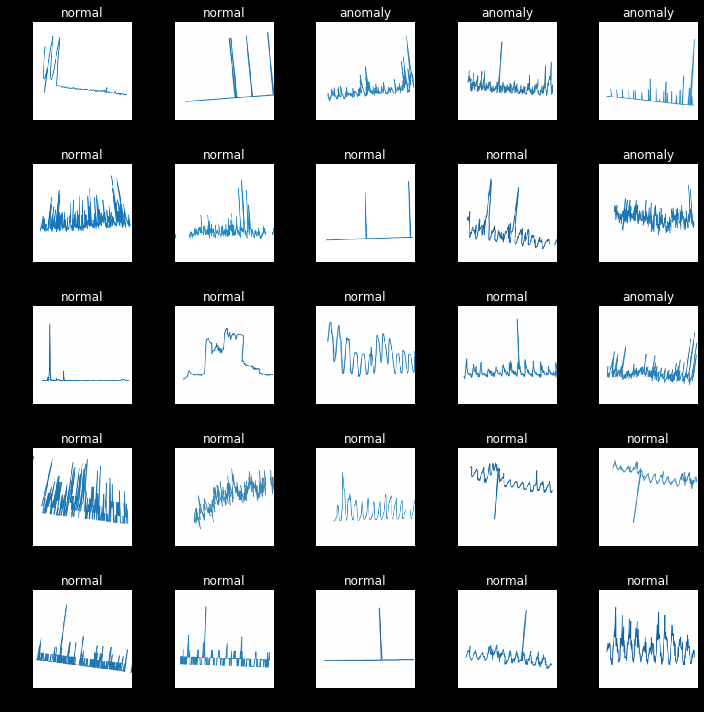

In [ ]:
data.show_batch(rows=5, figsize=(10,10))

## Train

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate


Amazingly, we get error rate of 3.25%!  This is somewhat surprising because we mixed up different metric domains.  We generally find with other algorithms that each time series behaves differently.

In [ ]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

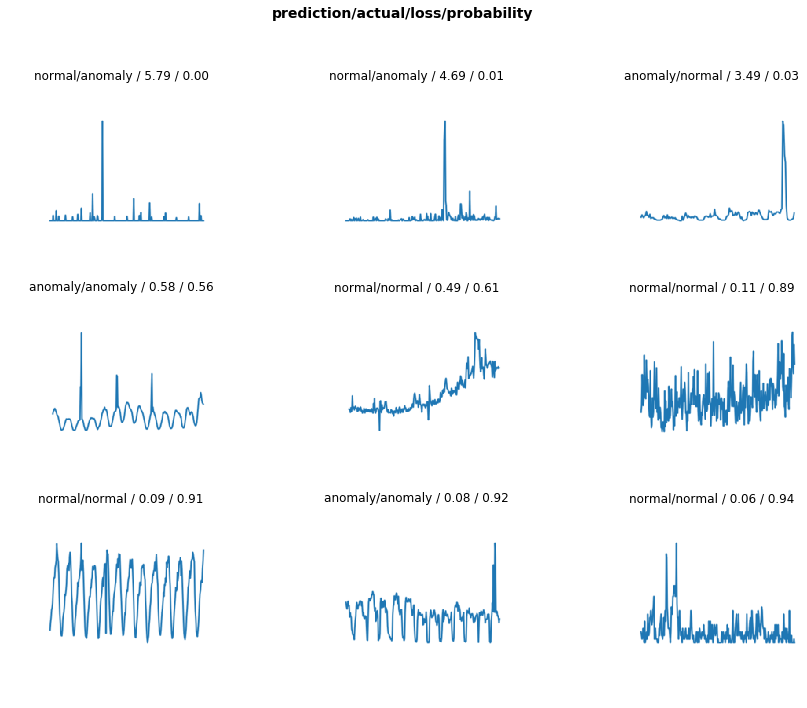

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

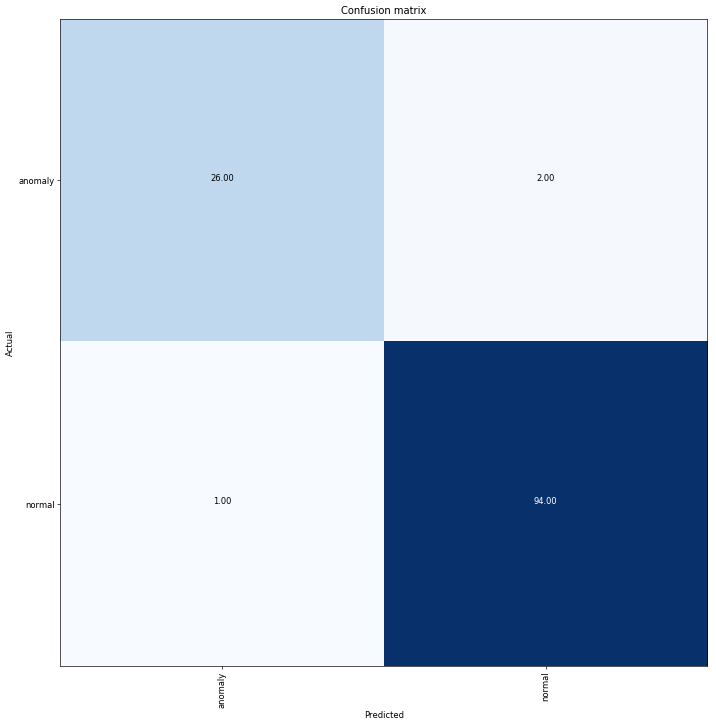

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:02
epoch  train_loss  valid_loss  error_rate
1      0.624110    32.504482   0.772358    (00:02)



In [ ]:
learn.load('stage-1')

In [ ]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


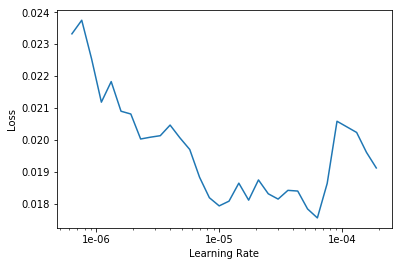

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,5e-5))

Total time: 00:21
epoch  train_loss  valid_loss  error_rate
1      0.015585    0.125522    0.024390    (00:02)
2      0.014140    0.124565    0.024390    (00:02)
3      0.015276    0.145958    0.024390    (00:02)
4      0.013339    0.150840    0.040650    (00:02)
5      0.013032    0.142768    0.040650    (00:02)
6      0.012381    0.135628    0.032520    (00:02)
7      0.010649    0.132180    0.024390    (00:02)
8      0.009463    0.131450    0.024390    (00:02)
9      0.008897    0.129096    0.024390    (00:02)
10     0.008093    0.129631    0.024390    (00:02)



## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data2 = ImageDataBunch.from_folder('bitmaps', df_tfms=get_transforms(do_flip=False, max_zoom=1), size=224, bs=bs//2, valid_pct=0.2)


In [ ]:
data2.normalize(imagenet_stats)

In [ ]:
learn2 = create_cnn(data2, models.resnet50, metrics=error_rate)

In [ ]:
learn2.fit_one_cycle(10)

Total time: 00:29
epoch  train_loss  valid_loss  error_rate
1      0.714029    0.721486    0.451852    (00:05)
2      0.470686    0.498920    0.192593    (00:02)
3      0.337360    0.209552    0.088889    (00:02)
4      0.249762    0.199853    0.074074    (00:02)
5      0.184177    0.179076    0.059259    (00:02)
6      0.134200    0.128874    0.037037    (00:02)
7      0.102580    0.134938    0.044444    (00:02)
8      0.075759    0.162498    0.029630    (00:02)
9      0.058497    0.165538    0.037037    (00:02)
10     0.044666    0.165741    0.044444    (00:02)



In [ ]:
learn2.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn2.unfreeze()
learn2.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 00:11
epoch  train_loss  valid_loss  error_rate
1      0.012719    0.145306    0.029630    (00:04)
2      0.009341    0.137647    0.037037    (00:03)
3      0.010234    0.136459    0.029630    (00:03)



If it doesn't, you can always go back to your previous model.

In [ ]:
learn2.load('stage-1-50')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn2)

In [ ]:
interp.most_confused(min_val=2)

[('anomaly', 'normal', 5)]

## EON